<a href="https://colab.research.google.com/github/Willy-Angole/Datasets/blob/master/Kenyan_Sign_Language.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -q  fastai==1.0.61

In [2]:
# check version of fastai
import fastai

fastai.__version__

'1.0.61'

In [3]:
# connect to gdrive
from google.colab import drive
drive.mount("/content/gdrive")


Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [5]:
import numpy as np 
import pandas as pd 

from fastai import *
from fastai.vision import *
from pathlib import Path
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [6]:
image_path = "/content/gdrive/MyDrive/Images"

### tfms helps to do data augmentation on the data to have a better pixel values

In [7]:
tfms=get_transforms(do_flip=True,flip_vert=True,max_lighting=0.3,max_zoom=1.8,max_warp=0.2,max_rotate=45)

### Read the data and pass the data augmentation function

In [8]:
df = pd.read_csv("/content/gdrive/MyDrive/Train.csv")

In [9]:
df.head()

,img_IDS,Label
0,ImageID_33HMDMJ3,Temple
1,ImageID_V5POEX4O,Church
2,ImageID_89CCCCW6,Enough/Satisfied
3,ImageID_GNJXOWX5,Me
4,ImageID_7Q9LOP7R,Love


In [ ]:
!pip install torch==1.4.0 torchvision==0.5.0

In [10]:
data = ImageDataBunch.from_df(image_path,
                              df,
                              size=224,
                              valid_pct=0.20,
                              ds_tfms=tfms,
                              num_workers=2,
                              bs=8,
                             suffix='.jpg').normalize(imagenet_stats)

In [ ]:
# There are 9 classes!
print(data.c) 

9


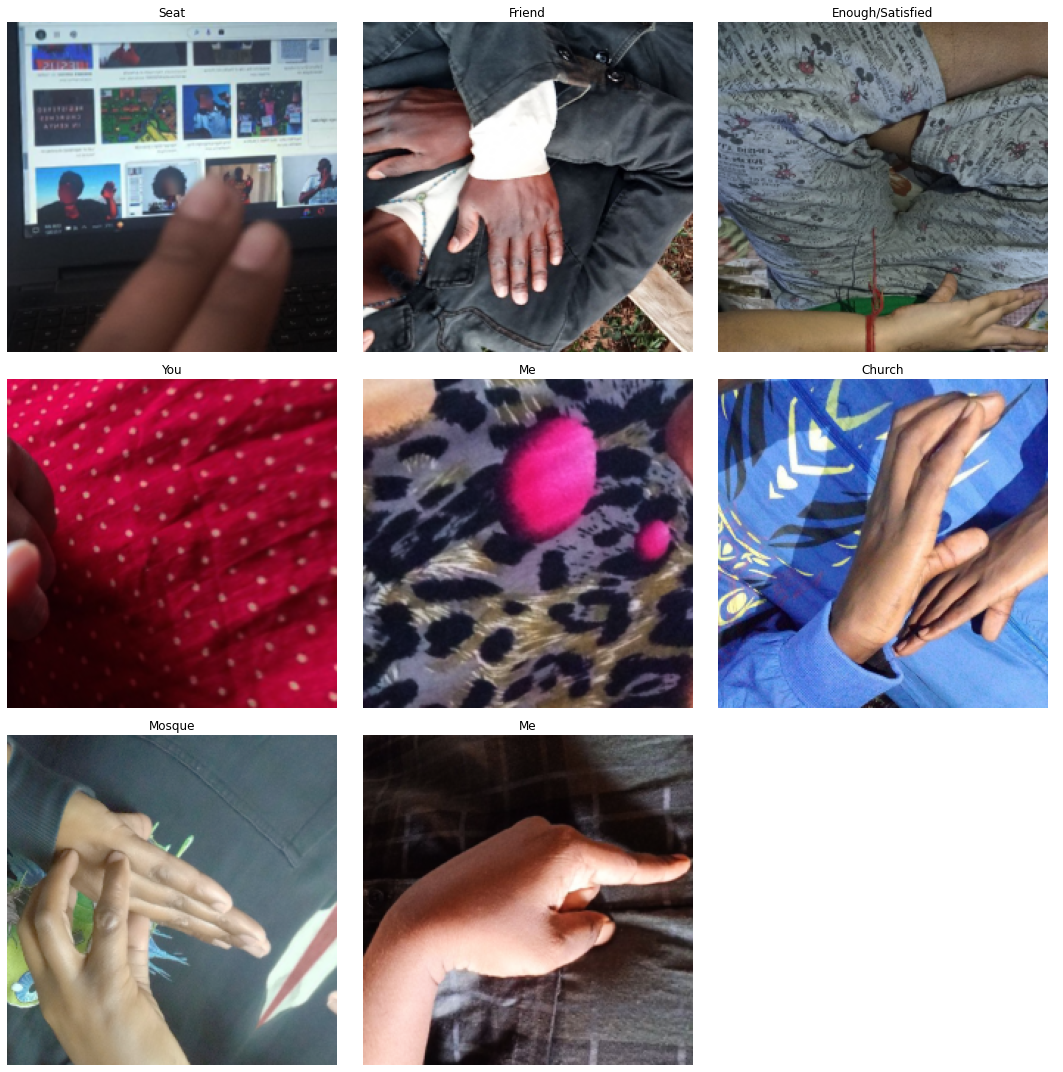

In [11]:
# Look at some examples
data.show_batch(rows=3, figsize=(15, 15)) 

### Create a baseline model using resnet18

In [12]:
learn = cnn_learner(data, models.resnet18, metrics=[error_rate, accuracy])

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/checkpoints/resnet18-5c106cde.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

In [13]:
# Fit
num_epochs = 3
learn.fit_one_cycle(num_epochs, 1e-4)

epoch,train_loss,valid_loss,error_rate,accuracy,time
0,2.940419,2.037935,0.714171,0.285829,53:50
1,2.654637,1.656802,0.585268,0.414732,04:23
2,2.673210,1.651660,0.573259,0.426741,04:23


## predict on test set

In [14]:
test_df = pd.read_csv("/content/gdrive/MyDrive/Test.csv")

In [15]:
test_df.head()

,img_IDS
0,ImageID_USRB8QNG
1,ImageID_SZ8D1ZJI
2,ImageID_4OJO2F8J
3,ImageID_IEE4XV0B
4,ImageID_BP0O0WZ9


In [16]:
test = ImageList.from_df(test_df, image_path, suffix='.jpg')

In [17]:
data.add_test(test)

In [20]:
preds_test,y_test = learn.get_preds(DatasetType.Test)

predictions

In [22]:
preds_test[:,1]

tensor([0.0365, 0.7000, 0.1958,  ..., 0.2146, 0.3497, 0.0314])

In [23]:
y_test

tensor([0, 0, 0,  ..., 0, 0, 0])

In [24]:
sub=pd.read_csv("/content/gdrive/MyDrive/SampleSubmission.csv")
k=[]
for col in sub.columns: 
  k.append(col) # creating list of the label

In [25]:
k

['img_IDS',
 'Church',
 'Enough/Satisfied',
 'Friend',
 'Love',
 'Me',
 'Mosque',
 'Seat',
 'Temple',
 'You']

In [26]:
import os
submission = pd.DataFrame()
submission["ID"] = test_df["img_IDS"]
for i, c in enumerate(learn.data.classes):
  print(c)
  submission[c] = preds_test[:,i]
submission.head()

Church
Enough/Satisfied
Friend
Love
Me
Mosque
Seat
Temple
You


,ID,Church,Enough/Satisfied,Friend,Love,Me,Mosque,Seat,Temple,You
0,ImageID_USRB8QNG,0.025715,0.036529,0.308233,0.116289,0.087791,0.211575,0.048937,0.155175,0.009756
1,ImageID_SZ8D1ZJI,0.160589,0.700004,0.003303,0.000773,0.002286,0.120631,0.010993,0.000741,0.000679
2,ImageID_4OJO2F8J,0.149082,0.195772,0.072499,0.030919,0.007042,0.303864,0.099992,0.131966,0.008864
3,ImageID_IEE4XV0B,0.112538,0.070489,0.075999,0.046966,0.010063,0.033814,0.431232,0.082035,0.136864
4,ImageID_BP0O0WZ9,0.008784,0.129299,0.068214,0.003546,0.005245,0.042272,0.057634,0.034563,0.650442


In [27]:
submission.to_csv('baseline_model.csv', index=False)